# Lecture 6 - Target Encoding

## Giới thiệu

Hầu hết các kỹ thuật mà chúng ta đã học trong khóa này đều áp dụng cho các đặc trưng số. Tuy nhiên, kỹ thuật mà chúng ta sẽ tìm hiểu trong bài học này, *target encoding*, lại được thiết kế dành cho các đặc trưng phân loại. Đây là một phương pháp mã hóa các danh mục thành số, tương tự như one-hot encoding hoặc label encoding, nhưng điểm khác biệt là nó sử dụng *mục tiêu* để tạo ra mã hóa. Điều này khiến target encoding trở thành một kỹ thuật **học có giám sát** (*supervised feature engineering*).

In [7]:
import pandas as pd

autos = pd.read_csv("autos.csv")

## Mã hóa theo mục tiêu (Target Encoding)

**Target encoding** là bất kỳ phương pháp mã hóa nào thay thế các danh mục của một đặc trưng bằng một giá trị số được tính toán từ mục tiêu.

Một phiên bản đơn giản và hiệu quả là áp dụng một phép tổng hợp theo nhóm từ Bài 3, chẳng hạn như giá trị trung bình. Khi sử dụng tập dữ liệu *Automobiles*, phương pháp này sẽ tính giá trung bình của từng hãng xe như sau:

In [8]:
autos["make_encoded"] = autos.groupby("make")["price"].transform("mean")

autos[["make", "price", "make_encoded"]].head(10)

,make,price,make_encoded
0,alfa-romero,13495,15498.333333
1,alfa-romero,16500,15498.333333
2,alfa-romero,16500,15498.333333
3,audi,13950,17859.166667
4,audi,17450,17859.166667
5,audi,15250,17859.166667
6,audi,17710,17859.166667
7,audi,18920,17859.166667
8,audi,23875,17859.166667
9,bmw,16430,26118.750000


Loại mã hóa theo mục tiêu này đôi khi được gọi là **mean encoding** (mã hóa theo trung bình). Khi áp dụng cho một mục tiêu nhị phân, nó cũng được gọi là **bin counting** (đếm tần suất). (Một số tên gọi khác mà bạn có thể gặp bao gồm: likelihood encoding, impact encoding, và leave-one-out encoding.)

## Làm mượt (Smoothing)

Tuy nhiên, kiểu mã hóa này có thể gặp một số vấn đề.

### *Danh mục chưa biết* (Unknown Categories) ##
Mã hóa theo mục tiêu có nguy cơ gây *overfitting* (quá khớp), do đó cần phải được huấn luyện trên một tập dữ liệu độc lập gọi là "encoding split". Khi bạn áp dụng mã hóa này vào các tập dữ liệu khác, Pandas sẽ tự động điền giá trị thiếu nếu một danh mục không có mặt trong tập encoding. Những giá trị thiếu này cần được xử lý theo một cách nào đó.

### *Danh mục hiếm* (Rare Categories) ##
Khi một danh mục chỉ xuất hiện vài lần trong tập dữ liệu, các thống kê tính toán trên nhóm đó có thể không chính xác. Trong tập dữ liệu *Automobiles*, hãng xe `mercury` chỉ xuất hiện một lần. Do đó, giá trung bình mà chúng ta tính được thực chất chỉ là giá của một chiếc xe duy nhất, điều này có thể không đại diện chính xác cho giá của các xe Mercury khác mà chúng ta có thể gặp trong tương lai. Mã hóa theo mục tiêu đối với các danh mục hiếm có thể làm tăng nguy cơ *overfitting*.

### Giải pháp: **Làm mượt (Smoothing)** ##
Một cách để giải quyết vấn đề này là thêm **làm mượt** (*smoothing*). Ý tưởng là pha trộn giá trị trung bình trong một danh mục với giá trị trung bình tổng thể. Các danh mục hiếm sẽ có trọng số thấp hơn đối với trung bình của riêng chúng, trong khi các danh mục chưa biết sẽ nhận giá trị trung bình tổng thể.

Pseudocode cho phương pháp này:
```python
encoding = weight * in_category + (1 - weight) * overall
```
Ở đây, `weight` là một giá trị nằm trong khoảng từ 0 đến 1, được tính dựa trên tần suất xuất hiện của danh mục.

Một cách đơn giản để xác định giá trị `weight` là sử dụng **ước lượng m** (*m-estimate*):
```python
weight = n / (n + m)
```
Trong đó, `n` là tổng số lần danh mục đó xuất hiện trong dữ liệu. Tham số `m` xác định "hệ số làm mượt" (*smoothing factor*). Giá trị `m` càng lớn thì trọng số đặt lên ước lượng tổng thể càng cao.

<figure style="padding: 1em;">
<img src="1uVtQEz.png" width=500 alt="">
<figcaption style="text-align: center; font-style: italic"><center></center></figcaption>
</figure>

Trong tập dữ liệu *Automobiles*, có ba chiếc xe thuộc hãng `chevrolet`. Nếu bạn chọn `m=2.0`, thì danh mục `chevrolet` sẽ được mã hóa bằng 60% giá trung bình của Chevrolet cộng với 40% giá trung bình tổng thể.
```python
chevrolet = 0.6 * 6000.00 + 0.4 * 13285.03
```
Khi chọn giá trị cho `m`, hãy cân nhắc mức độ nhiễu mà bạn mong đợi trong các danh mục. Giá của một chiếc xe có biến động nhiều trong mỗi hãng không? Bạn có cần nhiều dữ liệu để có được ước lượng chính xác không? Nếu vậy, có thể tốt hơn khi chọn một giá trị `m` lớn hơn. Nếu giá trung bình của mỗi hãng xe khá ổn định, thì một giá trị `m` nhỏ có thể là đủ.

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
<strong>Trường hợp sử dụng của Target Encoding</strong><br>
Target encoding rất hữu ích trong các tình huống sau:
<ul>
<li><strong>Đặc trưng có nhiều danh mục (High-cardinality features)</strong>: Một đặc trưng có số lượng danh mục lớn có thể khó mã hóa. One-hot encoding sẽ tạo ra quá nhiều đặc trưng, trong khi label encoding có thể không phù hợp. Target encoding tạo ra giá trị số cho các danh mục bằng cách sử dụng đặc tính quan trọng nhất của chúng: mối quan hệ với mục tiêu.
<li><strong>Đặc trưng có ý nghĩa từ kiến thức chuyên ngành (Domain-motivated features)</strong>: Dựa trên kinh nghiệm, bạn có thể nghi ngờ rằng một đặc trưng phân loại có thể quan trọng ngay cả khi nó có điểm thấp trong các tiêu chí đánh giá đặc trưng. Target encoding có thể giúp làm lộ ra mức độ quan trọng thực sự của đặc trưng đó.
</ul>
</blockquote>

## Ví dụ - MovieLens1M

Tập dữ liệu [*MovieLens1M*](https://www.kaggle.com/grouplens/movielens-20m-dataset) chứa một triệu lượt đánh giá phim từ người dùng trên trang web MovieLens, với các đặc trưng mô tả từng người dùng và từng bộ phim. Cell ẩn dưới đây thiết lập mọi thứ:

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings('ignore')


df = pd.read_csv("movielens1m.csv")
df = df.astype(np.uint8, errors='ignore') # reduce memory footprint
print("Number of Unique Zipcodes: {}".format(df["Zipcode"].nunique()))

Number of Unique Zipcodes: 3439


Với hơn 3000 danh mục, đặc trưng `Zipcode` là một ứng viên phù hợp để áp dụng target encoding. Ngoài ra, với kích thước tập dữ liệu lớn (hơn một triệu dòng), chúng ta có thể tách ra một phần dữ liệu để huấn luyện bộ mã hóa mà không ảnh hưởng nhiều đến mô hình.

Chúng ta sẽ bắt đầu bằng cách tạo một tập con 25% để huấn luyện target encoder.

In [10]:
X = df.copy()
y = X.pop('Rating')

X_encode = X.sample(frac=0.25)
y_encode = y[X_encode.index]
X_pretrain = X.drop(X_encode.index)
y_train = y[X_pretrain.index]

Gói `category_encoders` trong `scikit-learn-contrib` cung cấp một bộ mã hóa m-estimate, và chúng ta sẽ sử dụng nó để mã hóa đặc trưng `Zipcode`.

In [11]:
from category_encoders import MEstimateEncoder

# Create the encoder instance. Choose m to control noise.
encoder = MEstimateEncoder(cols=["Zipcode"], m=5.0)

# Fit the encoder on the encoding split.
encoder.fit(X_encode, y_encode)

# Encode the Zipcode column to create the final training data
X_train = encoder.transform(X_pretrain)

Hãy so sánh các giá trị đã được mã hóa với mục tiêu để đánh giá mức độ thông tin mà mã hóa của chúng ta có thể cung cấp.

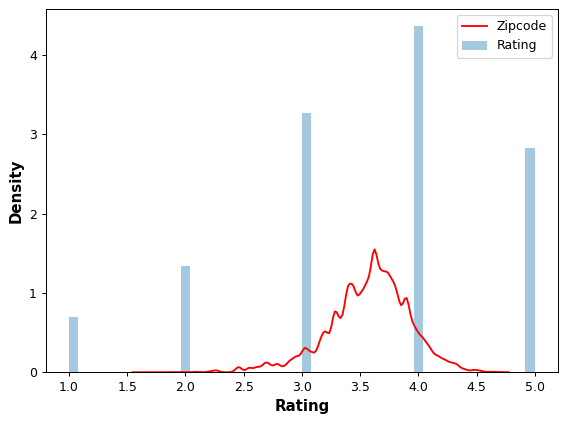

In [12]:
plt.figure(dpi=90)
ax = sns.distplot(y, kde=False, norm_hist=True)
ax = sns.kdeplot(X_train.Zipcode, color='r', ax=ax)
ax.set_xlabel("Rating")
ax.legend(labels=['Zipcode', 'Rating']);

Phân bố của đặc trưng `Zipcode` sau khi mã hóa nhìn chung tương đồng với phân bố của các đánh giá thực tế, điều này cho thấy rằng người xem phim có sự khác biệt đủ lớn trong đánh giá của họ giữa các mã vùng. Nhờ đó, target encoding có thể nắm bắt được thông tin hữu ích.

## Đến lượt bạn

[**Áp dụng target encoding**](https://www.kaggle.com/kernels/fork/14393917) vào các đặc trưng trong *Ames* và khám phá một cách bất ngờ mà target encoding có thể dẫn đến overfitting.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/feature-engineering/discussion) to chat with other learners.*